# 2020년 서울자전거 따릉이 대여소 증설에 따른 이용자 분산 양상

## 송상록

# 1. 분석 문제

본 분석에서 참고한 뉴스기사는 파이낸셜뉴스 <코로나로 '따릉이' 인기 폭발, 서울시 하반기 1만대 추가 도입>이다. (https://www.fnnews.com/news/202009071402560124)기사의 핵심 내용은 2020년에 서울특별시의 공공 자전거 대여 서비스 '따릉이'의 자전거 대여소가 추가로 대량 설치되고 있다는 것이다. 기존에는 한 대여소에 사람들이 몰려 이미 자전거가 없어 따릉이 서비스를 이용하지 못하는 경우가 있었는데, 올해 대여소 증설을 통해 이용자 수가 분산되어 이러한 문제가 크게 완화되었다고 한다. 본 분석에서는 자치구별로 대여소 증설에 따른 이용자 수 분산이 실제로 이루어졌는지를 데이터를 통해 검증해 보고자 한다. 또한 이러한 양상을 살펴보고 자치구별로 어떠한 점에서 따릉이 관리를 개선해야 할지 고찰해 보도록 하겠다.

* 핵심 탐구 질문: 2020년 따릉이 대여소 증설이 자치구별로 어떠한 효과가 있었는지 알아보자.

## 데이터 출처

본 분석에서는 서울 열린데이터광장의 '서울특별시 공공자전거 대여소 정보 (https://data.seoul.go.kr/dataList/OA-13252/F/1/datasetView.do)'와 '서울특별시 공공자전거 대여이력 정보 (https://data.seoul.go.kr/dataList/OA-15182/F/1/datasetView.do)' 데이터를 사용하였다. 대여이력 정보는 달별로 데이터 파일이 따로 있었는데, 서울 열린데이터광장에서 일부 월의 데이터를 아직 업로드하지 않아 찾는 데 어려움이 있었다. 특히 2020년 7월 이후로는 대여이력 정보 데이터가 전혀 없었다. 그러므로 제일 확실한 기준인 2020년 및 2019년 6월 대여이력 정보를 데이터로 사용하기로 했다. 데이터 csv 파일은 압축파일 내에서 확인할 수 있다.

## 구체적인 분석 방법
전체 따릉이 대여소 및 대여이력 데이터를 자치구별로 그룹화시킨 뒤, 두 가지 분석을 진행한다. 우선 전반적인 이용자 분산 양상을 확인하기 위해, 하루에 한 따릉이 자전거가 몇 번 대여됐는지를 계산하고 2019년과 2020년간 차이가 얼마나 발생했는지 확인한다. 다음으로 2020년에 새로 설치된 대여소의 이용 비율이 자치구별로 얼마나 되는지를 확인한다. 이후 두 분석의 결과를 종합하여 분산 효과가 얼마나 발생했는지에 따라 각 자치구를 분류하고, 앞으로 어떠한 방법으로 개선할 수 있을지 방법을 모색한다.

# 2. 데이터클리닝

## 패키지 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 한글 폰트 불러오기

In [ ]:
import matplotlib as mpl

%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')
mpl.font_manager._rebuild()

mpl.rcParams['axes.unicode_minus'] = False

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


## 데이터 불러오기

### 공공자전거 대여소 정보 불러오기

In [ ]:
df_loc = pd.read_csv("/content/drive/My Drive/공공자전거 대여소 정보(20.07.13 기준).csv", encoding = "cp949", header = 0)
df_loc = df_loc.drop([0, 1, 2, 3, 2087])
df_loc = df_loc.reset_index()
df_loc = df_loc.drop(['index'], axis = 1)
df_loc.columns = ["대여소번호", "대여소명", "자치구", "주소", "위도", "경도", "설치시기", "LCD", "QR", "운영 방식"]
df_loc = df_loc.fillna(0)
df_loc.대여소번호 = pd.to_numeric(df_loc.대여소번호, downcast = "integer")
df_loc.LCD = pd.to_numeric(df_loc.LCD, downcast = "integer")
df_loc.QR = pd.to_numeric(df_loc.QR, downcast = "integer")
df_loc.설치시기 = pd.to_datetime(df_loc.설치시기, format = '%Y/%m/%d', errors = "raise")
df_loc["자전거수"] = df_loc.LCD + df_loc.QR
df_loc["설치연도"] = df_loc.설치시기.dt.year
df_loc = df_loc.drop(['LCD', 'QR'], axis = 1)
df_loc.head()

,대여소번호,대여소명,자치구,주소,위도,경도,설치시기,운영 방식,자전거수,설치연도
0,1695,월계미륭아파트 정문,노원구,노원구 월계동 14,37.623417,127.066933,2020-06-17,QR,10,2020
1,2301,현대고등학교 건너편,강남구,서울특별시 강남구 압구정로 134,37.524071,127.021790,2017-06-13,LCD,10,2017
2,2302,교보타워 버스정류장(신논현역 3번출구 후면),강남구,서울특별시 강남구 봉은사로 지하 102,37.505581,127.024277,2017-06-13,LCD,10,2017
3,2303,논현역 7번출구,강남구,서울특별시 강남구 학동로 지하 102,37.511517,127.021477,2017-06-13,LCD,15,2017
4,2304,신영 ROYAL PALACE 앞,강남구,서울특별시 강남구 언주로 626,37.512527,127.035835,2017-06-13,LCD,10,2017


참고: 운영 방식이 LCD인 따릉이는 2019년까지 계속 사용되어 온 기존 방식이고, 2020년부터 QR 따릉이가 새로 도입되었다. 운영 방식이 QR인 경우 거의 무조건 2020년에 새로 세워진 대여소로 보면 된다.

### 2020년 6월 공공자전거 대여이력 정보 불러오기

In [ ]:
df_2020 = pd.read_csv("/content/drive/My Drive/공공자전거 대여이력 정보_202006.csv", encoding = "cp949", header = 0)
df_2020 = df_2020.loc[df_2020.이용시간 >= 5]
df_2020.대여일시 = pd.to_datetime(df_2020.대여일시, format = '%Y-%m-%d %H:%M:%S', errors = "raise")
df_2020.반납일시 = pd.to_datetime(df_2020.반납일시, format = '%Y-%m-%d %H:%M:%S', errors = "raise")
df_2020.sort_values(by = "대여일시", inplace = True)
df_2020 = df_2020.reset_index()
df_2020.head()

,index,자전거번호,대여일시,대여 대여소번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간,이용거리
0,190,SPB-22338,2020-06-01 00:00:00,106,합정역 7번출구 앞,6,2020-06-01 00:41:00,830,청암자이아파트앞,3,40,6430.0
1,3,SPB-19763,2020-06-01 00:00:16,956,응암시장교차로,8,2020-06-01 00:08:25,939,은평구청 교차로,6,7,1340.0
2,30,SPB-23789,2020-06-01 00:00:24,2340,삼호물산버스정류장(23370) 옆,1,2020-06-01 00:14:50,2263,바우뫼문화복지회관,20,13,1950.0
3,79,SPB-22476,2020-06-01 00:00:32,3511,응봉역 1번출구,9,2020-06-01 00:21:38,362,청계8가 사거리,2,21,5320.0
4,5,SPB-33628,2020-06-01 00:00:34,1153,"발산역 1번, 9번 인근 대여소",0,2020-06-01 00:09:35,1125,명덕고교입구(영종빌딩),0,9,0.0


대여 이력 중 이용시간이 5분도 안 되는 경우는 분석에서 제외하기로 했다. 생각보다 장난으로 따릉이를 예약한 후 바로 반납하거나, 사용 방법을 잘 몰라 실수로 반납을 바로 해 버리는 상황이 있기 때문이다.

### 2019년 6월 공공자전거 대여이력 정보 불러오기

In [ ]:
df_2019a = pd.read_csv("/content/drive/My Drive/서울특별시 공공자전거 대여정보_201906_1.csv", encoding = "cp949", header = 0)
df_2019b = pd.read_csv("/content/drive/My Drive/서울특별시 공공자전거 대여정보_201906_2.csv", encoding = "cp949", header = 0)
df_2019c = pd.read_csv("/content/drive/My Drive/서울특별시 공공자전거 대여정보_201906_3.csv", encoding = "cp949", header = 0)
df_2019 = pd.concat([df_2019a, df_2019b, df_2019c])
df_2019 = df_2019.loc[df_2019.이용시간 >= 5]
df_2019.대여일시 = pd.to_datetime(df_2019.대여일시, format = '%Y-%m-%d %H:%M:%S', errors = "raise")
df_2019.반납일시 = pd.to_datetime(df_2019.반납일시, format = '%Y-%m-%d %H:%M:%S', errors = "raise")
df_2019.sort_values(by = "대여일시", inplace = True)
df_2019 = df_2019.drop_duplicates().reset_index()
df_2019.head()

,index,자전거번호,대여일시,대여 대여소번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간,이용거리
0,288994,SPB-15924,2019-06-01 00:00:02,2000,신도림4차 e편한세상 아파트 1109동 앞,8,2019-06-01 00:41:19,2183,동방1교,2,40,9040.0
1,571197,SPB-09991,2019-06-01 00:00:08,1321,국민은행 종암동지점 앞,10,2019-06-01 00:15:36,1362,보문역6번출구 앞,10,15,2590.0
2,662251,SPB-23204,2019-06-01 00:00:09,1709,쌍문역4번출구 주변,15,2019-06-01 00:20:11,1525,미아동 복합청사,3,19,2820.0
3,227821,SPB-12658,2019-06-01 00:00:09,2102,봉림교 교통섬,20,2019-06-01 00:22:39,2107,도림천 신화교,2,20,1650.0
4,83304,SPB-16229,2019-06-01 00:00:09,131,증산2교,13,2019-06-01 00:36:49,906,연신내역 5번출구150M 아래,2,36,4180.0


2019년 데이터는 3개로 분리되어 있어 concat 함수를 통해 통합시켰다.

# 3. 2020년 전반적인 따릉이 대여소 증설의 양상

## 서울 전체 연도별 증설 정도

In [ ]:
df_year = df_loc.groupby(['설치연도']).sum()
df_year = df_year[['자전거수']].cumsum()
df_year['증설자전거수'] = (df_year.자전거수 - df_year.자전거수.shift()).fillna(0)
df_year['전년대비증가율'] = (df_year.증설자전거수 / df_year.자전거수.shift() * 100).fillna(0)
df_year.head()

,자전거수,증설자전거수,전년대비증가율
설치연도,,,
2015,2077.0,0.0,0.000000
2016,5794.0,3717.0,178.960039
2017,15382.0,9588.0,165.481533
2018,19194.0,3812.0,24.782213
2019,19474.0,280.0,1.458789


우선 서울 전체 연도별로 따릉이 대여소가 얼마나 증설되었는지 확인하기 위해, groupby 함수를 이용하여 연도별 따릉이 대여소 내 자전거 수 총합을 계산하였다.  실제로 이용되는 따릉이 자전거 수와 대여소별 최대 주차 가능 자전거의 수에는 약간의 차이가 있을 수 있으나, 실제로도 대여소를 증설해야 자전거가 더 투입되기 때문에 대체로 그 양상은 정확하리라 생각한다.

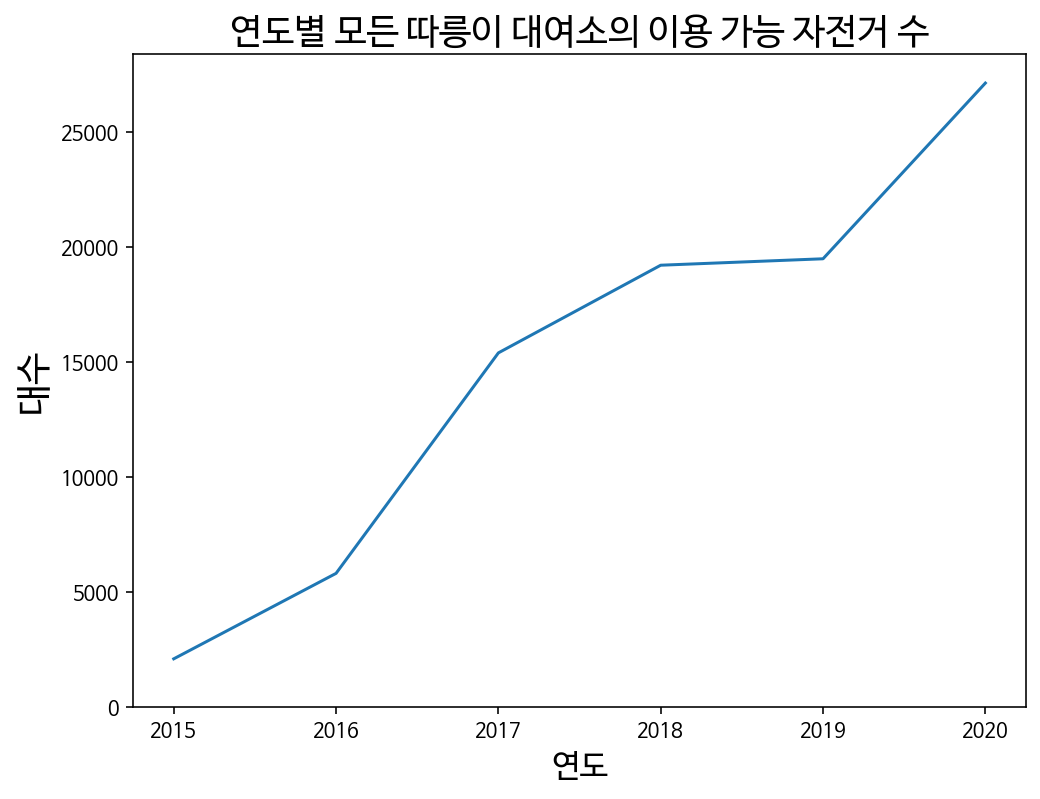

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(df_year.자전거수)
plt.title('연도별 모든 따릉이 대여소의 이용 가능 자전거 수',  fontsize=18)
plt.xlabel('연도', fontsize=16)
plt.ylabel('대수', fontsize=18)
plt.yticks(np.arange(0, 30000, step=5000), fontsize=10)
plt.show()

2019년 ~ 2020년의 따릉이 대여소 증설은 2017년 이후로 제일 큰 규모라고 볼 수 있다. 2016년 ~ 2017년에도 한 차례의 대규모 증설이 있었는데, 이 당시의 증설은 따릉이 서비스가 완전히 정착하지 않아 이를 보다 보급하기 위한 목적이였다. 현재 2019년 ~ 2020년의 증설은 각 따릉이 대여소의 이용자 수를 분산하기 위한 의도로 볼 수 있겠다. 시각화를 통해 그래프를 확인해도 2020년의 따릉이 대여소 증설 폭은 다른 연도에 비해 상당히 큼을 알 수 있다.

## 자치구별 연도별 증설 정도

In [ ]:
df_district = df_loc.groupby(['자치구', '설치연도']).sum()
df_district = df_district[['자전거수']].groupby(level=[0]).cumsum()
df_district['증설자전거수'] = (df_district.자전거수 - df_district.자전거수.shift()).fillna(0)
df_district.loc[df_district.증설자전거수 < 0, ['증설자전거수']] = 0
df_district['전년대비증가율'] = (df_district.증설자전거수 / df_district.자전거수.shift() * 100).fillna(0)
df_district.reset_index(level=['자치구', '설치연도'], inplace = True)
df_district.head()

,자치구,설치연도,자전거수,증설자전거수,전년대비증가율
0,강남구,2017,953.0,0.0,0.000000
1,강남구,2018,1227.0,274.0,28.751312
2,강남구,2019,1242.0,15.0,1.222494
3,강남구,2020,1482.0,240.0,19.323671
4,강동구,2017,579.0,0.0,0.000000


이번엔 groupby 함수의 기준을 자치구와 설치연도 2개로 설정했고 동일 과정을 반복했다.

In [ ]:
df_district2 = df_district.loc[df_district.설치연도 == 2020]
df_district2['전년자전거수'] = df_district2['자전거수'] - df_district2['증설자전거수']
df_district2.sort_values(by = '전년대비증가율', inplace = True, ascending = False)
df_district2.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,자치구,설치연도,자전거수,증설자전거수,전년대비증가율,전년자전거수
104,중구,2020,865.0,387.0,80.962343,478.0
12,강서구,2020,1756.0,735.0,71.988247,1021.0
37,도봉구,2020,676.0,273.0,67.741935,403.0
47,동작구,2020,866.0,345.0,66.218810,521.0
58,서대문구,2020,1035.0,388.0,59.969088,647.0


각 자치구별로 2019년에 비해 2020년 따릉이 자전거 수의 증가율을 계산해 보니 전반적으로 중구, 강서구, 도봉구, 동작구 등 구의 자전거 대여소 증설 비율이 제일 높았음을 알 수 있다. 다만 자전거의 증가 정도로만은 이용자 수가 실제로 분산되었는지를 알 수 없으므로, 이는 이후 분석을 통해 확인해야 한다.

# 4. 따릉이 대여소 증설의 이용자 수 분산 효과

앞서 진행한 분석의 한계는 실제로 따릉이 대여소 증설이 이용자 수 분산을 불러일으켰는지를 알 수 없다는 점이다. 그 여부를 본 분석에서 파악하고자 한다.

## 추가 데이터클리닝

In [ ]:
df_use2019 = df_2019.merge(df_loc, left_on='대여 대여소번호', right_on = '대여소번호')
df_use2019 = df_use2019[['대여소번호', '대여소명', '자치구', '주소', '설치연도']]
df_use2019.head()

,대여소번호,대여소명,자치구,주소,설치연도
0,2000,신도림4차 e편한세상 아파트 1109동 앞,구로구,구로구 신도림동 312-16,2019
1,2000,신도림4차 e편한세상 아파트 1109동 앞,구로구,구로구 신도림동 312-16,2019
2,2000,신도림4차 e편한세상 아파트 1109동 앞,구로구,구로구 신도림동 312-16,2019
3,2000,신도림4차 e편한세상 아파트 1109동 앞,구로구,구로구 신도림동 312-16,2019
4,2000,신도림4차 e편한세상 아파트 1109동 앞,구로구,구로구 신도림동 312-16,2019


각 자치구별 이용건수를 확인하기 위해서는 대여이력 데이터를 사용해야 한다. 이 때 대여이력 데이터 파일에는 자치구가 없기 때문에, 대여 장소의 대여소 번호를 이용하여 앞서 대여소 데이터와 inner join을 진행한다. 반납 장소보단 대여 장소에서 이용자 수를 분산하는 것이 더 중요하기에, 반납 대여소는 생략하고 대여 대여소 위주로 분석을 진행하겠다. (inner join인 만큼 일부 이용 데이터가 사라졌는데, 사라진 대여소이거나 일부 대여소 정보가 데이터 기관 담당자 착오로 누락되었을 가능성이 있다.)

In [ ]:
df_count2019 = pd.DataFrame(df_use2019.groupby(['자치구']).count().대여소번호)
df_count2019 = df_count2019.rename(columns={'대여소번호': '이용건수'})
df_count2019.head()

,이용건수
자치구,
강남구,89885
강동구,72290
강북구,36883
강서구,125328
관악구,73324


자치구별로 group을 해 줄 시, 6월 한 달 간 자치구별 따릉이 이용 건수를 확인할 수 있다.

In [ ]:
df_use2020 = df_2020.merge(df_loc, left_on='대여 대여소번호', right_on = '대여소번호')
df_use2020 = df_use2020[['대여소번호', '대여소명', '자치구', '주소', '설치연도']]
df_use2020.head()

,대여소번호,대여소명,자치구,주소,설치연도
0,106,합정역 7번출구 앞,마포구,서울특별시 마포구 독막로 4,2015
1,106,합정역 7번출구 앞,마포구,서울특별시 마포구 독막로 4,2015
2,106,합정역 7번출구 앞,마포구,서울특별시 마포구 독막로 4,2015
3,106,합정역 7번출구 앞,마포구,서울특별시 마포구 독막로 4,2015
4,106,합정역 7번출구 앞,마포구,서울특별시 마포구 독막로 4,2015


In [ ]:
df_count2020 = pd.DataFrame(df_use2020.groupby(['자치구']).count().대여소번호)
df_count2020 = df_count2020.rename(columns={'대여소번호': '이용건수'})
df_count2020.head()

,이용건수
자치구,
강남구,55669
강동구,63518
강북구,30751
강서구,137319
관악구,60914


마찬가지의 절차를 2020년 데이터에도 반복한다.

## 분석 1) 자치구별 따릉이 1대 당 하루 평균 대여 횟수

우선 자치구별로 대여소 증설의 이용자 수 분산 효과를 알아보기 위해, 따릉이 1대 당 하루 평균 대여 횟수를 계산한다. 2019년 대여 건 수와 2019년 자전거 수의 비율, 그리고 2019년 대여 건 수와 2020년 자전거 수의 비율을 계산해 보고 얼마나 변했는지를 확인한다. (2020년의 총 대여 건수가 2019년에 비해 40000건 가량 감소했음을 고려하여, 만약 2019년의 수요를 2020년의 자전거 수가 견딜 수 있을지 확인하는 것이 더 의미있다고 판단했다.)

따릉이 1대 당 하루 평균 대여 횟수를 구한 뒤, 이에 따라 다음과 같이 '분산 정도'를 임의로 구분했다.
* 3.5번 이상: (매우 혼잡): 대여소가 텅텅 비어 있을 때가 매우 많다.
* 2.5번 이상 3.5번 미만: (다소 혼잡) 가끔 대여소에 갔는데 자전거가 없어 헛발질을 하는 경우가 있다.
* 2.5번 미만: (양호) 정말 운이 없는 경우가 아닌 이상 웬만하면 대여소에서 자전거를 찾을 수 있다.

In [ ]:
df_counts = df_count2019.merge(df_count2020, on = "자치구", suffixes = ("_2019", "_2020"))
df_ratio = df_counts.merge(df_district2, on = "자치구")
df_ratio = df_ratio[['자치구', '이용건수_2019', '이용건수_2020', '전년자전거수', '자전거수']]
df_ratio['2019비율'] = df_ratio['이용건수_2019'] / 30 / df_ratio['전년자전거수']
df_ratio['2020비율'] = df_ratio['이용건수_2019'] / 30 / df_ratio['자전거수']
df_ratio['감소율'] = (df_ratio['2020비율'] - df_ratio['2019비율']) / df_ratio['2019비율'] * 100
df_ratio["2019수준"] = ""
df_ratio["2020수준"] = ""

for index, (r1, r2) in enumerate(zip(df_ratio['2019비율'], df_ratio['2020비율'])):
  if r1 >= 3.5:
    df_ratio.iloc[index, 8] = '매우혼잡'
  elif r1 >= 2.5:
    df_ratio.iloc[index, 8] = '다소혼잡'
  else:
    df_ratio.iloc[index, 8] = '양호'

  if r2 >= 3.5:
    df_ratio.iloc[index, 9] = '매우혼잡'
  elif r2 >= 2.5:
    df_ratio.iloc[index, 9] = '다소혼잡'
  else:
    df_ratio.iloc[index, 9] = '양호'

df_ratio.sort_values(by='2020비율', ascending=False, inplace=True)
df_ratio.head()

,자치구,이용건수_2019,이용건수_2020,전년자전거수,자전거수,2019비율,2020비율,감소율,2019수준,2020수준
5,광진구,122237,82620,858.0,1050.0,4.748912,3.880540,-18.285714,매우혼잡,매우혼잡
12,마포구,145610,113281,1075.0,1303.0,4.515039,3.724994,-17.498081,매우혼잡,매우혼잡
19,영등포구,159506,137520,1231.0,1485.0,4.319144,3.580382,-17.104377,매우혼잡,매우혼잡
17,송파구,175960,127671,1260.0,1765.0,4.655026,3.323135,-28.611898,매우혼잡,다소혼잡
15,성동구,92940,71813,755.0,957.0,4.103311,3.237200,-21.107628,매우혼잡,다소혼잡


계산의 편의를 위해 자치구별 이용 건수 데이터프레임을 자치구별 대여소 수 데이터프레임과 inner join을 한 뒤 계산을 진행했다. 조건 및 반복문을 사용하여 분산 정도 역시 기록한다.

In [ ]:
before = np.sum(df_ratio['이용건수_2019']) / 30 / np.sum(df_ratio['전년자전거수'])
after = np.sum(df_ratio['이용건수_2019']) / 30 / np.sum(df_ratio['자전거수'])
change = (after - before) / before * 100
print(before, after, change)

3.425053918044572 2.45987460815047 -28.179974184030975


전국적으로는 1대 당 하루 평균 대여 횟수가 약 3.43건 (다소 혼잡) 에서 2.46건 (양호)으로 28% 감소하였다.

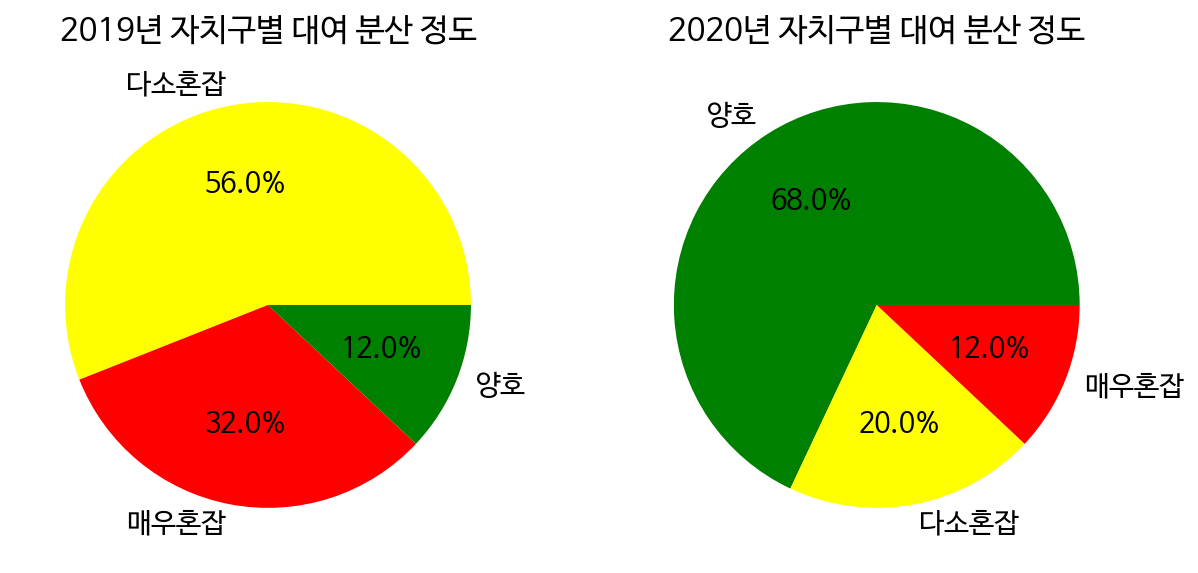

In [ ]:
plt.figure(figsize = (10, 8))
plt.subplot(1, 2, 1)
plt.rc('font', size = 14)
plt.pie(df_ratio['2019수준'].value_counts(), labels = df_ratio['2019수준'].value_counts().index, autopct='%.1f%%', colors=["yellow", "red", "green"])
plt.title('2019년 자치구별 대여 분산 정도', fontsize=16)

plt.subplot(1, 2, 2)
plt.rc('font', size = 14)
plt.pie(df_ratio['2020수준'].value_counts(), labels = df_ratio['2020수준'].value_counts().index, autopct='%.1f%%', colors=["green", "yellow", "red"])
plt.title('2020년 자치구별 대여 분산 정도', fontsize=16)

plt.show()

자치구별 대여 분산 정도에 따라 2019년 및 2020년 파이 그래프를 동시에 그려 보았다. 확실히 매우 혼잡 및 다소 혼잡 정도의 자치구가 줄고, 양호 정도의 자치구가 늘었음을 알 수 있다.

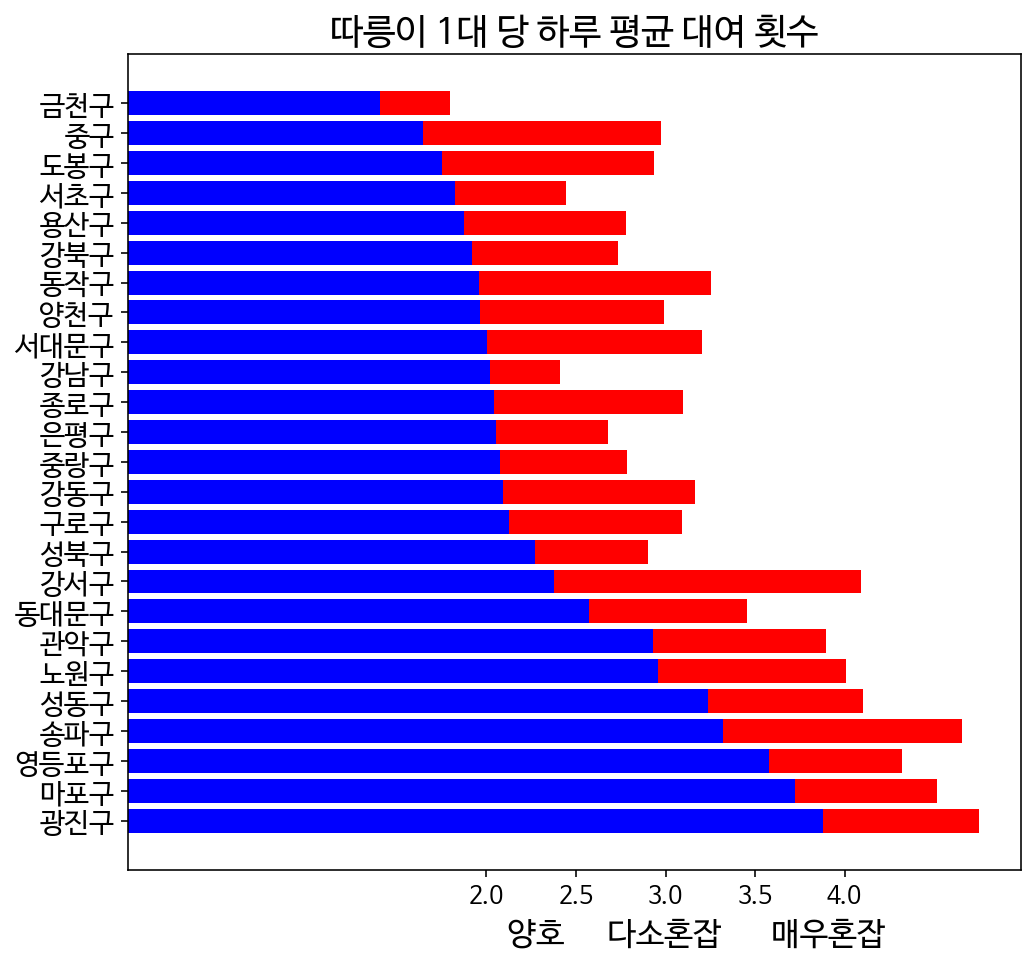

In [ ]:
plt.figure(figsize=(8, 7.5))
plt.barh(df_ratio.자치구, df_ratio['2019비율'], color = 'r')
plt.barh(df_ratio.자치구, df_ratio['2020비율'], color = 'b')
plt.title("따릉이 1대 당 하루 평균 대여 횟수", fontsize=18)
plt.xlabel('                                            양호      다소혼잡       매우혼잡          ', fontsize=16)
plt.xticks(np.arange(2, 4.5, 0.5), fontsize=12)
plt.yticks(fontsize=14)
plt.show()

막대 그래프로 하루 평균 한 대의 따릉이가 대여되는 횟수를 확인해 보면, 강서구나 송파구 등 기존에 매우 혼잡했던 자치구들의 대여 상황이 많이 개선되었음을 알 수 있다.

## 분석 2) 자치구별 2020년에 지어진 새 대여소의 이용 비율

두 번째로 전체적 및 각 자치구별로 2020년에 지어진 새 대여소의 이용 비율이 얼마나 되는지를 알아보고자 한다. 새 대여소의 이용 비율이 높을수록 이용자 수 분산 효과를 크게 누리고 있다고 볼 수 있다. 2020년 6월 이용 건수 데이터를 연도 및 자치구별로 group해주면 확인이 가능하다. (이 때 연도는 해당 대여소가 설치된 해를 의미한다.)

In [ ]:
df_newuse2020 = pd.DataFrame(df_use2020.groupby(['자치구', '설치연도']).count().대여소번호)
df_newuse2020 = df_newuse2020.rename(columns={'대여소번호': '이용건수'})
df_newuse2020.reset_index(level=['자치구', '설치연도'], inplace = True)
df_newuse2020 = df_newuse2020[df_newuse2020.설치연도 == 2020]
df_newuse2020 = df_newuse2020.merge(df_count2020, on='자치구', suffixes=('_신규', '_전체'))
df_newuse2020['이용비율'] = df_newuse2020['이용건수_신규'] / df_newuse2020['이용건수_전체'] * 100
df_newuse2020.sort_values(by='이용비율', ascending = True, inplace = True)
df_newuse2020.head()

,자치구,설치연도,이용건수_신규,이용건수_전체,이용비율
4,관악구,2020,899,60914,1.475851
21,은평구,2020,910,50997,1.784419
5,광진구,2020,1820,82620,2.202856
6,구로구,2020,1652,65809,2.510295
24,중랑구,2020,1132,44116,2.565962


groupby 및 merge 등을 통해 dataframe을 변형하여 신규 대여소의 이용 비율을 계산한다.

In [ ]:
newusetotal = np.sum(df_newuse2020['이용건수_신규']) / np.sum(df_newuse2020['이용건수_전체']) * 100
print(newusetotal)

6.939421891209458


서울 전체적으로는 6.93% 정도의 이용 비율을 보였다.

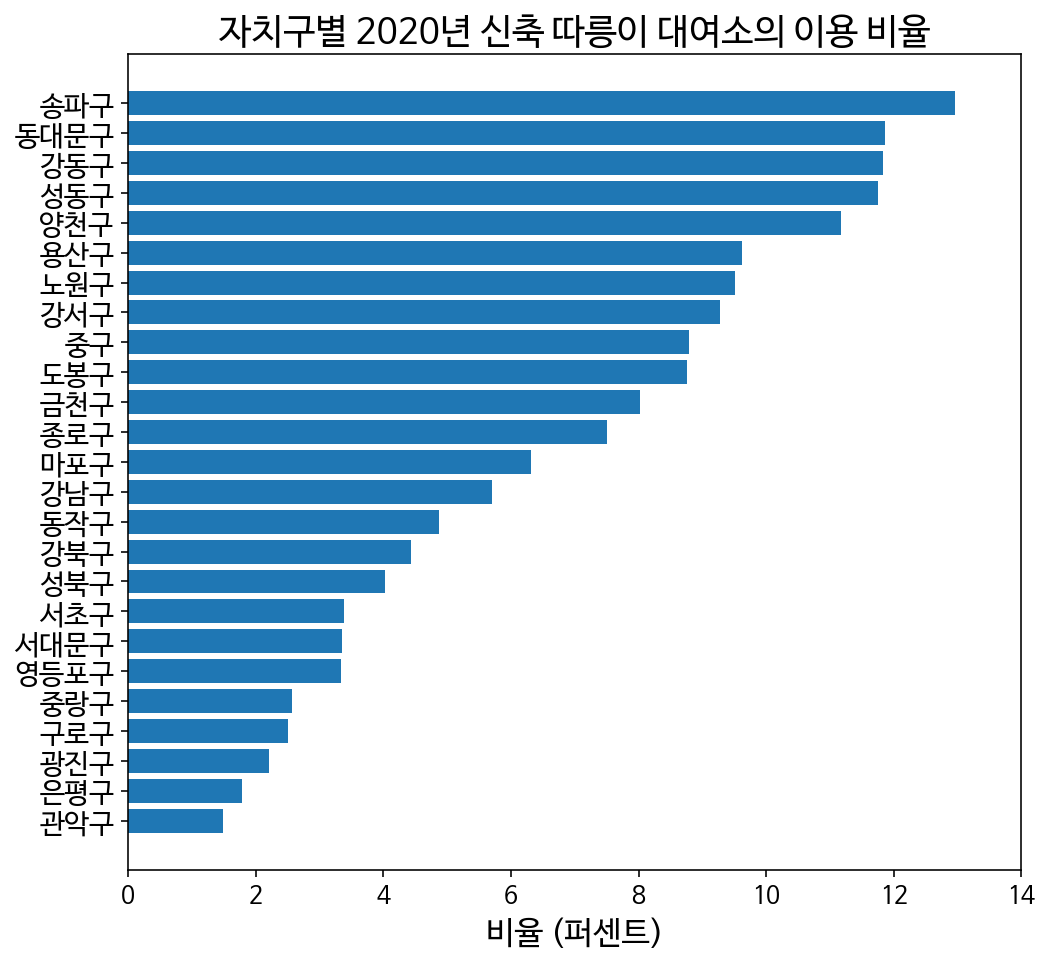

In [ ]:
plt.figure(figsize=(8, 7.5))
plt.barh(df_newuse2020.자치구, df_newuse2020.이용비율)
plt.title("자치구별 2020년 신축 따릉이 대여소의 이용 비율", fontsize=18)
plt.xlabel('비율 (퍼센트)', fontsize=16)
plt.xticks(np.arange(0, 16, 2), fontsize=12)
plt.yticks(fontsize=14)
plt.show()

총 이용 건수 중 신축 대여소 이용 건수가 많을수록 성공적으로 이용자 수가 분산되었다고 볼 수 있다. 앞서 혼잡도가 상당히 낮아진 송파구나 강서구 등 구 역시 상당한 분산 정도를 보였다.

# 5. 정리) 구별 따릉이 대여소 증설의 효과 비교

하루 평균 한 대의 따릉이가 대여되는 횟수가 더 큰 폭으로 감소됐을수록, 그리고 신축 따릉이 대여소의 이용 비율이 높을수록 보다 이용자 수의 분산 효과가 확실히 나타난 구라고 볼 수 있다. 이에 따라 구별로 과연 따릉이 대여소 증설의 효과가 제대로 이루어졌는지를 파악해 볼 수 있겠다. 본인만의 판단 기준을 통해 분류해 보도록 하겠다.

* 신축 따릉이 대여소의 이용률이 약 6.93% (서울 평균) 이상이면서 2020년 대여소의 이용 정도가 '양호'인 경우: 경우 A
* 신축 따릉이 대여소의 이용률이 약 6.93% 이상이 아니고, 2020년 대여소의 이용 정도가 '양호'인 경우: 경우 B
* 신축 따릉이 대여소의 이용률이 약 6.93% 이상이지만, 2020년 대여소의 이용 정도가 '다소혼잡' 혹은 '매우혼잡'인 경우: 경우 C
* 신축 따릉이 대여소의 이용률이 약 6.93% 이상이 아니고, 2020년 대여소의 이용 정도가 '다소혼잡' 혹은 '매우혼잡'인 경우: 경우 D







In [ ]:
df_summary = df_ratio.merge(df_newuse2020, on="자치구")
df_summary = df_summary[['자치구', '이용건수_전체', '이용비율', '2019비율', '2019수준', '2020비율', '2020수준']]
df_summary.head()

,자치구,이용건수_전체,이용비율,2019비율,2019수준,2020비율,2020수준
0,광진구,82620,2.202856,4.748912,매우혼잡,3.880540,매우혼잡
1,마포구,113281,6.319683,4.515039,매우혼잡,3.724994,매우혼잡
2,영등포구,137520,3.336969,4.319144,매우혼잡,3.580382,매우혼잡
3,송파구,127671,12.955957,4.655026,매우혼잡,3.323135,다소혼잡
4,성동구,71813,11.761102,4.103311,매우혼잡,3.237200,다소혼잡


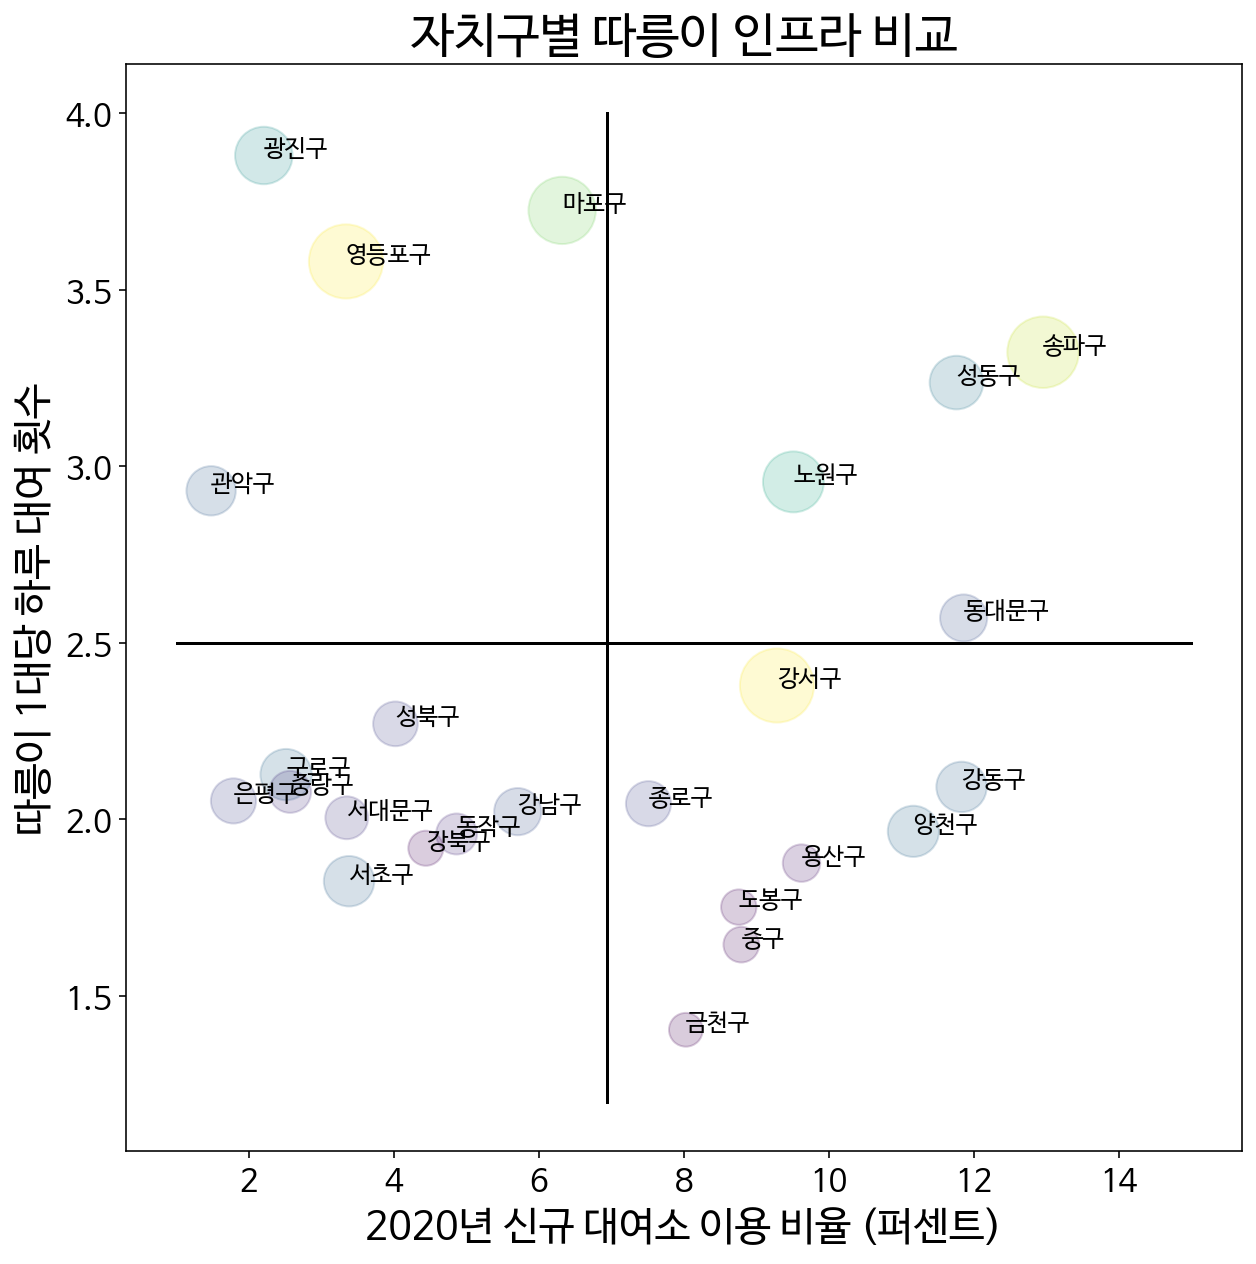

In [ ]:
z = df_summary.이용비율
y = df_summary['2020비율']
n = df_summary.자치구
plt.figure(figsize = (10, 10))
plt.title('자치구별 따릉이 인프라 비교', fontsize = 24)
plt.scatter(z, y, s = df_summary.이용건수_전체 / 100, c = df_summary.이용건수_전체, alpha = 0.2)
plt.xlabel('2020년 신규 대여소 이용 비율 (퍼센트)', fontsize=20)
plt.ylabel('따릉이 1대당 하루 대여 횟수', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot([newusetotal, newusetotal], [1.2, 4], 'k-')
plt.plot([1, 15], [2.5, 2.5], 'k-')
for i, txt in enumerate(n):
    plt.annotate(txt, (z[i], y[i]), fontsize=12)
plt.show()

오른쪽 아래는 경우 A, 왼쪽 아래는 경우 B, 오른쪽 위는 경우 C, 왼쪽 위는 경우 D에 속한다.

## 경우 A

In [ ]:
df_summary.loc[(df_summary.이용비율 > newusetotal) & (df_summary['2020비율'] < 2.5)]

,자치구,이용건수_전체,이용비율,2019비율,2019수준,2020비율,2020수준
8,강서구,137319,9.284221,4.091675,매우혼잡,2.379043,양호
11,강동구,63518,11.831292,3.162292,다소혼잡,2.091725,양호
14,종로구,50977,7.511231,3.099695,다소혼잡,2.044195,양호
17,양천구,65517,11.166567,2.990940,다소혼잡,1.965890,양호
20,용산구,35062,9.622954,2.778934,다소혼잡,1.875868,양호
22,도봉구,31334,8.757260,2.937469,다소혼잡,1.751183,양호
23,중구,31813,8.792003,2.976709,다소혼잡,1.644933,양호
24,금천구,28515,8.027354,1.797262,양호,1.403719,양호


경우 A에 속한 구는 이전에는 상당히 따릉이 대여 환경이 혼잡했으나, 따릉이 대여소 증설 덕분에 보다 쉽고 쾌적하게 따릉이를 대여할 수 있게 된 구에 속한다. 특히 강서구 같은 경우는 기존에는 하루에 한 개의 따릉이가 4건 이상 대여될 만큼 매우 혼잡했는데 확실히 이용자 수가 분산되면서 그 건수가 2~3건 정도로 낮아졌다. 이번 분산 정책의 모범적인 예시라고 볼 수 있겠다.

## 경우 B

In [ ]:
df_summary.loc[(df_summary.이용비율 < newusetotal) & (df_summary['2020비율'] < 2.5)]

,자치구,이용건수_전체,이용비율,2019비율,2019수준,2020비율,2020수준
9,성북구,49905,4.019637,2.902763,다소혼잡,2.270386,양호
10,구로구,65809,2.510295,3.092851,다소혼잡,2.126672,양호
12,중랑구,44116,2.565962,2.782738,다소혼잡,2.077778,양호
13,은평구,50997,1.784419,2.676096,다소혼잡,2.052061,양호
15,강남구,55669,5.706946,2.412373,양호,2.021705,양호
16,서대문구,45822,3.347737,3.206285,다소혼잡,2.004316,양호
18,동작구,41910,4.862801,3.255214,다소혼잡,1.958391,양호
19,강북구,30751,4.438880,2.732074,다소혼잡,1.917993,양호
21,서초구,63593,3.379303,2.443295,양호,1.824607,양호


경우 B에 속한 구는 원래부터 따릉이 사용 환경이 비교적 양호한 편이여서 비교적 대여소 증설에 의한 이용자 수 분산 효과가 덜 나타난 구라고 볼 수 있겠다. 특히 강남구와 서초구는 이미 따릉이 인프라가 잘 발달되어 있어서 크게 이용자 수가 분산되지는 않았다.

## 경우 C

In [ ]:
df_summary.loc[(df_summary.이용비율 > newusetotal) & (df_summary['2020비율'] > 2.5)]

,자치구,이용건수_전체,이용비율,2019비율,2019수준,2020비율,2020수준
3,송파구,127671,12.955957,4.655026,매우혼잡,3.323135,다소혼잡
4,성동구,71813,11.761102,4.103311,매우혼잡,3.237200,다소혼잡
5,노원구,92888,9.511455,4.007197,매우혼잡,2.955854,다소혼잡
7,동대문구,55514,11.860071,3.455640,다소혼잡,2.570278,다소혼잡


경우 C에 속한 구는 확실히 따릉이 대여소 증설의 효과는 보이지만, 혼잡도를 더욱 낮추기 위해 더 많은 대여소 증설이 필요한 자치구라고 할 수 있다. 대표적인 예가 송파구인데, 무려 전체 이용 건수 중 12%가 신축 대여소를 사용할 정도로 이용자 분산은 잘 이루어졌지만, 여전히 전반적인 이용 환경이 꽤나 혼잡하다.

## 경우 D

In [ ]:
df_summary.loc[(df_summary.이용비율 < newusetotal) & (df_summary['2020비율'] > 2.5)]

,자치구,이용건수_전체,이용비율,2019비율,2019수준,2020비율,2020수준
0,광진구,82620,2.202856,4.748912,매우혼잡,3.880540,매우혼잡
1,마포구,113281,6.319683,4.515039,매우혼잡,3.724994,매우혼잡
2,영등포구,137520,3.336969,4.319144,매우혼잡,3.580382,매우혼잡
6,관악구,60914,1.475851,3.898139,매우혼잡,2.930616,다소혼잡


경우 D에 속한 구는 아직 갈 길이 멀다. 새로 지은 따릉이 대여소로 수요가 분산된 것도 아니고, 그렇다고 원래부터 따릉이 이용 인프라가 그렇게까지 좋았던 구도 아니다. 그런 의미에서 더더욱 따릉이 대여소 증설을 위해 노력해야 한다. 특히 신규 대여소 이용객이 1.47%밖에 안 되는 관악구는 수요에 맞게 더 많은 대여소를 증설할 필요가 있다. (관악구에 사는 본인도 주말도 아닌 평일에 따릉이 타려고 나왔다가 허탕을 많이 쳤다.)